In [19]:
import pathlib
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set_style("white")
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [20]:
df = pd.read_csv("/kaggle/input/pip-neo-big-five-personality-120-item-version/IPIP120-SCORES.csv")

In [21]:
# 如果环境里还没有 openai
!pip install --quiet openai

In [22]:
# 配置python
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations
from scipy import stats
from scipy.stats import wasserstein_distance


In [23]:
# 我的openAI API key 配置
from kaggle_secrets import UserSecretsClient

from openai import OpenAI

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("OPENAI_API_KEY")

client = OpenAI(api_key=secret_value_0)


In [24]:
# 随机种子方便复现
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 在 /kaggle/input 下面看到的真实data路径
DATA_PATH = "/kaggle/input/pip-neo-big-five-personality-120-item-version/IPIP120-SCORES.csv"

# 这五个列名要和CSV 对上, 我检查过了对其
DOMAINS = [
    "openness",
    "conscientiousness",
    "extraversion",
    "agreeableness",
    "neuroticism",
]


In [25]:
# 读上传的 dataset
def load_human_scores(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 分sex → sex_label
    if "sex" in df.columns:
        sex_map = {1: "male", 2: "female"}
        if df["sex"].dtype != object:
            df["sex_label"] = df["sex"].map(sex_map).fillna(df["sex"].astype(str))
        else:
            df["sex_label"] = df["sex"]
    else:
        df["sex_label"] = "unknown"

    # 分age → age_bin
    if "age" in df.columns:
        bins = [0, 17, 25, 35, 50, 120]
        labels = ["<=17", "18-25", "26-35", "36-50", "50+"]
        df["age_bin"] = pd.cut(
            df["age"],
            bins=bins,
            labels=labels,
            right=True,
            include_lowest=True,
        )
    else:
        df["age_bin"] = "unknown"

    return df


human = load_human_scores(DATA_PATH)
human.head()


,case,sex,age,sec,min,hour,day,month,year,country,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12,i13,i14,i15,i16,i17,i18,i19,i20,i21,i22,i23,i24,i25,i26,i27,i28,i29,i30,i31,i32,i33,i34,i35,i36,i37,i38,i39,i40,...,i108,i109,i110,i111,i112,i113,i114,i115,i116,i117,i118,i119,i120,openness,facet_imagination,facet_artistic_interests,facet_emotionality,facet_adventurousness,facet_intellect,facet_liberalism,conscientiousness,facet_self_efficacy,facet_orderliness,facet_dutifulness,facet_achievement_striving,facet_self_discipline,facet_cautiousness,extraversion,facet_friendliness,facet_gregariousness,facet_assertiveness,facet_activity_level,facet_excitement_seeking,facet_cheerfulness,agreeableness,facet_trust,facet_morality,facet_altruism,facet_cooperation,facet_modesty,facet_sympathy,neuroticism,facet_anxiety,facet_anger,facet_depression,facet_self_consciousness,facet_immoderation,facet_vulnerability,sex_label,age_bin
0,1,2,19,8,41,16,30,6,101,South Afr,5,4,5,4,4,2,5,5,4,4,2,4,4,4,4,1,2,4,5,4,5,4,4,3,2,2,4,2,4,4,2,4,4,4,4,2,4,4,4,1,...,3,4,4,5,2,4,4,4,2,4,1,5,4,64.796448,75.254232,40.432058,73.068513,71.832186,59.478950,36.369613,59.184103,59.751318,32.342786,54.892857,63.675297,41.888264,84.032423,56.493023,74.071748,65.945007,77.299926,12.265075,23.740125,66.964675,84.214345,73.438475,72.159605,67.393775,76.776519,74.954334,77.384533,35.573367,27.993157,11.549711,58.018551,39.725121,96.864432,11.048211,female,18-25
1,2,2,22,24,45,16,30,6,101,USA,5,4,4,2,5,5,5,4,5,4,4,4,5,5,4,3,5,5,1,4,1,5,3,4,4,3,2,5,4,3,4,4,5,2,4,5,4,4,5,5,...,4,2,5,1,4,3,3,4,4,2,3,4,3,79.613711,64.308584,61.025761,31.735332,88.251745,57.360264,92.935640,68.648552,89.733171,68.013111,44.963610,16.580116,84.633574,67.456166,80.144284,77.267973,94.271135,47.536294,96.065024,87.511279,5.776425,47.158018,13.978142,83.405900,89.448233,4.270395,69.646885,67.981348,66.998550,58.854938,89.843818,89.880570,57.486716,1.000000,80.327511,female,18-25
2,6,1,13,14,6,17,30,6,101,USA,2,4,2,2,4,4,5,4,3,2,2,4,2,2,4,2,3,5,1,4,1,5,5,2,4,1,3,3,2,4,2,4,5,2,5,5,4,2,3,2,...,5,1,5,1,2,4,3,5,2,4,4,3,5,64.261833,53.844029,45.316184,3.200967,90.676932,74.703513,90.450637,74.412693,93.299004,24.272619,14.383704,80.885654,99.646135,74.813500,80.931850,70.526550,86.659049,39.758576,92.707965,73.646661,65.158443,1.000000,7.526992,7.408120,2.417954,3.278791,24.018170,12.400848,22.577376,33.979027,86.802916,29.000871,7.509259,6.890607,15.131043,male,<=17
3,7,2,18,25,11,17,30,6,101,USA,3,4,3,2,5,4,4,4,3,3,2,5,4,4,5,1,5,5,2,4,4,4,5,3,3,1,3,2,3,2,2,4,2,3,5,4,5,4,5,4,...,3,4,5,2,3,4,4,5,2,4,2,4,3,55.968730,8.914197,60.988360,49.758720,81.244372,86.121119,25.431828,83.546408,84.580163,65.878251,78.953690,82.391009,83.566408,60.403585,84.255079,74.071748,81.190659,96.180870,97.498896,23.740125,56.848582,44.246158,27.248015,72.159605,54.492760,52.320264,38.542547,41.268613,12.466800,12.195029,57.719898,18.108659,8.870845,44.831762,5.285188,female,18-25
4,8,2,24,19,25,17,30,6,101,USA,4,4,4,5,4,2,3,4,4,4,3,3,5,5,4,3,3,4,5,4,3,3,4,5,3,3,5,4,4,3,2,4,3,4,4,1,4,4,5,3,...,2,4,2,3,2,4,4,3,1,5,3,4,4,55.117886,53.832540,61.025761,44.585253,41.349092,47.129696,69.477439,38.370685,49.695823,52.603005,44.963610,16.580116,43.843893,42.280102,50.534797,49.513820,59.439053,37.789326,41.578470,22.776857,88.517103,77.026790,83.907554,58.955730,66.457831,82.330021,50.199377,55.939489,26.353107,21.800273,7.899414,26.475441,38.817649,62.697315,53.029251,female,18-25


In [26]:
# 人类基准线
def describe_group(df: pd.DataFrame, group_cols, targets=DOMAINS) -> pd.DataFrame:
    outs = []
    for t in targets:
        if t not in df.columns:
            continue
        tmp = (
            df.groupby(group_cols)[t]
            .agg(["mean", "std", "count"])
            .reset_index()
            .rename(columns={"count": "n"})
        )
        tmp["metric"] = t
        outs.append(tmp)
    if outs:
        return pd.concat(outs, ignore_index=True)
    return pd.DataFrame()


baseline_sex = describe_group(human, ["sex_label"])
baseline_age = describe_group(human, ["age_bin"])

display(baseline_sex.head())
display(baseline_age.head())


,sex_label,mean,std,n,metric
0,female,40.064585,28.026286,241930,openness
1,male,40.911304,28.240421,168446,openness
2,female,55.447934,28.759354,241930,conscientiousness
3,male,55.270530,28.607323,168446,conscientiousness
4,female,51.519078,27.720936,241930,extraversion


,age_bin,mean,std,n,metric
0,<=17,37.863644,27.740394,70399,openness
1,18-25,38.943726,27.928452,207775,openness
2,26-35,43.425322,28.158871,74323,openness
3,36-50,43.843438,28.120005,45581,openness
4,50+,48.881715,28.842094,12298,openness


In [27]:
# persona 定义给Openai的 + 人类过滤，筛选18-25的人来对比
PERSONAS = [
    {
        "name": "US_male(18-25)",
        "prompt_snippet": "You are a 21-year-old male college student in the United States.",
        "human_filter": {"sex_label": ["male"], "age_bin": ["18-25"]},
    },
    {
        "name": "US_female(18-25)",
        "prompt_snippet": "You are a 21-year-old female college student in the United States.",
        "human_filter": {"sex_label": ["female"], "age_bin": ["18-25"]},
    },
    {
        "name": "Chinese_international_student(18-25)",
        "prompt_snippet": "You are a 21-year-old Chinese international student studying in the United States.",
        "human_filter": {"age_bin": ["18-25"]},
    },
]


def apply_filter(df: pd.DataFrame, flt: dict) -> pd.DataFrame:
    out = df.copy()
    for k, vals in flt.items():
        if k in out.columns:
            out = out[out[k].isin(vals)]
    return out


In [28]:
# prompt + 带 fallback 的调用函数（防止我的APIKEY过期,Fallback的输出会在开头有括号提示，只是为了运行流畅不出现卡顿）
IPIP_INSTRUCTION = (
    "You will answer a Big Five personality questionnaire (IPIP-NEO 120).\n"
    "Answer each item with an integer from 1 to 5 only:\n"
    "1 = Strongly disagree\n"
    "2 = Disagree\n"
    "3 = Neither agree nor disagree\n"
    "4 = Agree\n"
    "5 = Strongly agree\n"
    "Return ONLY the number."
)


def build_item_prompt(persona_snippet: str, item_text: str) -> str:
    return (
        persona_snippet.strip()
        + "\n\n"
        + IPIP_INSTRUCTION
        + "\nItem: "
        + item_text.strip()
        + "\nAnswer (1-5):"
    )


def parse_likert(resp: str) -> int:
    resp = resp.strip()
    for ch in resp:
        if ch.isdigit():
            v = int(ch)
            if 1 <= v <= 5:
                return v
    return 3

# 这边就是假的了 fallback生成防止我的api出问题不用在意，我的输出是正常的API调用输出
def fallback_score(persona_name: str, item_id: int) -> int:
    """
    本地生成一个确定性的 1..5，保证 notebook 能跑到底
    """
    base = abs(hash(persona_name + str(item_id)))
    return (base % 5) + 1


def call_llm_with_fallback(prompt: str, persona_name: str, item_id: int, model: str = "gpt-4o-mini") -> str:
    """
    先试 openai，失败就用 fallback
    """
    try:
        resp = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=16,
        )
        return resp.choices[0].message.content.strip()
    except Exception as e:
        # 打个简单的标记，方便在 Kaggle 的输出里看到是 fallback 触发
        print(f"[fallback] {persona_name} item {item_id} -> {e}")
        return str(fallback_score(persona_name, item_id))


In [29]:
# ipip120的题目构造同时分 5 段防止API usage alert
item_ids = list(range(1, 121))
items_df = pd.DataFrame(
    {
        "item_id": item_ids,
        "item_text": [f"Item {i}" for i in item_ids],
    }
)

def item_to_domain(item_id: int) -> str:
    idx = (item_id - 1) // 24  # 0..4
    return DOMAINS[idx]

items_df["domain"] = items_df["item_id"].apply(item_to_domain)
items_df["reversed"] = 0


In [30]:
# OpenAI gpt4omini模型 跑问卷，gpt5太贵了 
def run_llm_survey_batched(
    persona: dict,
    items: pd.DataFrame,
    model: str = "gpt-4o-mini",
    max_items: int | None = None,
    batch_size: int = 5,
) -> pd.DataFrame:
    """
    一次问好几道题，减少 API 次数。
    要求模型按行输出 1~5，比如：
    1
    3
    4
    2
    5
    """
    rows = []
    sub = items.sort_values("item_id")
    if max_items is not None:
        sub = sub.head(max_items)

    # 分块
    for start in range(0, len(sub), batch_size):
        chunk = sub.iloc[start:start + batch_size]

        # 把这一小批题合成一个 prompt
        q_lines = []
        for i, (_, it) in enumerate(chunk.iterrows(), start=1):
            q_lines.append(f"{i}. {it['item_text']}")
        questions_block = "\n".join(q_lines)

        prompt = (
            persona["prompt_snippet"].strip()
            + "\n\n"
            + "You will answer several IPIP-NEO style items.\n"
            + "Answer EACH item with ONLY an integer from 1 to 5, one per line, in order.\n"
            + "1 = Strongly disagree\n"
            + "2 = Disagree\n"
            + "3 = Neither agree nor disagree\n"
            + "4 = Agree\n"
            + "5 = Strongly agree\n\n"
            + "Items:\n"
            + questions_block
            + "\n\nYour answers (one number per line):"
        )

        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
                max_tokens=32,
            )
            text = resp.choices[0].message.content.strip()
        except Exception as e:
            # 打不过就全 fallback
            print(f"[fallback batch] {persona['name']} {chunk['item_id'].tolist()} -> {e}")
            text = "\n".join(
                str((abs(hash(persona["name"] + str(int(it["item_id"])))) % 5) + 1)
                for _, it in chunk.iterrows()
            )

        # 把模型的多行答案拆开
        answers = [line.strip() for line in text.splitlines() if line.strip()]
        # 不够的补 3（用不到，答案全是正常输出，主要防止离谱的fallback输出）
        while len(answers) < len(chunk):
            answers.append("3")

        # 逐题写回去
        for ans, (_, it) in zip(answers, chunk.iterrows()):
            score = parse_likert(ans)
            if int(it["reversed"]) == 1:
                score = 6 - score
            rows.append(
                {
                    "persona": persona["name"],
                    "item_id": int(it["item_id"]),
                    "domain": it["domain"],
                    "score": int(score),
                    "raw_response": ans,
                }
            )

    return pd.DataFrame(rows)


In [31]:
# 所有 persona 一起跑
all_item_answers = []
for p in PERSONAS:
    df_p = run_llm_survey_batched(
        persona=p,
        items=items_df,
        model="gpt-4o-mini",
        max_items=120,   # 总共跑 120次问答测试
        batch_size=5,# 每次请求 5 题， 120 题只要 24 次 5题是gpt4omini的单次问询上线
    )
    all_item_answers.append(df_p)

df_llm_items = pd.concat(all_item_answers, ignore_index=True)
df_llm_items.head()


,persona,item_id,domain,score,raw_response
0,US_male(18-25),1,openness,3,3
1,US_male(18-25),2,openness,4,4
2,US_male(18-25),3,openness,2,2
3,US_male(18-25),4,openness,5,5
4,US_male(18-25),5,openness,1,1


In [32]:
# 按 persona + domain 聚合
df_llm_domains = (
    df_llm_items
    .groupby(["persona", "domain"])["score"]
    .mean()
    .reset_index()
    .pivot(index="persona", columns="domain", values="score")
    .reset_index()
)
df_llm_domains


domain,persona,agreeableness,conscientiousness,extraversion,neuroticism,openness
0,Chinese_international_student(18-25),3.416667,3.541667,3.458333,3.458333,3.500000
1,US_female(18-25),3.250000,3.166667,3.125000,3.083333,3.250000
2,US_male(18-25),2.958333,3.083333,3.041667,3.000000,3.083333


In [33]:
# 和 Kaggle 的人类数据对比
def compare_llm_to_human(
    human_df: pd.DataFrame,
    llm_domains_df: pd.DataFrame,
    persona_dict: dict,
) -> pd.DataFrame:
    persona_name = persona_dict["name"]
    hdf = apply_filter(human_df, persona_dict.get("human_filter", {}))
    llm_row = llm_domains_df[llm_domains_df["persona"] == persona_name]

    results = []
    for d in DOMAINS:
        if d not in human_df.columns:
            continue

        human_vals = hdf[d].dropna().astype(float).values
        if human_vals.size == 0:
            results.append(
                {
                    "persona": persona_name,
                    "domain": d,
                    "llm_mean": np.nan,
                    "human_mean": np.nan,
                    "mean_diff": np.nan,
                    "cohens_d": np.nan,
                    "w1": np.nan,
                    "human_n": 0,
                }
            )
            continue

        human_mean = human_vals.mean()
        human_std = human_vals.std(ddof=1)

        if llm_row.shape[0] == 0 or d not in llm_row.columns:
            llm_mean = np.nan
        else:
            llm_mean = float(llm_row.iloc[0][d])

        mean_diff = llm_mean - human_mean
        if human_std > 0:
            d_cohen = mean_diff / human_std
        else:
            d_cohen = np.nan

        w1 = wasserstein_distance([llm_mean], human_vals)

        results.append(
            {
                "persona": persona_name,
                "domain": d,
                "llm_mean": llm_mean,
                "human_mean": human_mean,
                "mean_diff": mean_diff,
                "cohens_d": d_cohen,
                "w1": w1,
                "human_n": human_vals.size,
            }
        )
    return pd.DataFrame(results)


all_cmp = []
for p in PERSONAS:
    all_cmp.append(compare_llm_to_human(human, df_llm_domains, p))

df_cmp = pd.concat(all_cmp, ignore_index=True)
df_cmp


,persona,domain,llm_mean,human_mean,mean_diff,cohens_d,w1,human_n
0,US_male(18-25),openness,3.083333,39.709155,-36.625821,-1.304391,36.981761,86308
1,US_male(18-25),conscientiousness,3.083333,55.888351,-52.805018,-1.862020,52.928416,86308
2,US_male(18-25),extraversion,3.041667,55.988250,-52.946583,-1.910994,53.086930,86308
3,US_male(18-25),agreeableness,2.958333,52.887455,-49.929122,-1.878622,50.061052,86308
4,US_male(18-25),neuroticism,3.000000,42.838866,-39.838866,-1.446752,39.996435,86308
5,US_female(18-25),openness,3.250000,38.399853,-35.149853,-1.264002,35.562373,121467
6,US_female(18-25),conscientiousness,3.166667,56.706717,-53.540051,-1.871895,53.677631,121467
7,US_female(18-25),extraversion,3.125000,51.507717,-48.382717,-1.782288,48.552120,121467
8,US_female(18-25),agreeableness,3.250000,51.545020,-48.295020,-1.806506,48.477576,121467
9,US_female(18-25),neuroticism,3.083333,45.802602,-42.719269,-1.524366,42.886963,121467


In [34]:
# 因为原本数据集 human 那个五大人格是 0~120 这种大分值
human_scaled = human.copy()
for col in DOMAINS:
    if col in human_scaled.columns:
        max_val = human_scaled[col].max()
        # 防止除以0
        if max_val > 0:
            # 把人类的这个人格分数压到 1~5
            human_scaled[col] = 1 + 4 * (human_scaled[col] / max_val)

# 然后用 human_scaled 再跑一遍对比
all_cmp_scaled = []
for p in PERSONAS:
    cmp_df = compare_llm_to_human(human_scaled, df_llm_domains, p)
    all_cmp_scaled.append(cmp_df)

df_cmp_scaled = pd.concat(all_cmp_scaled, ignore_index=True)
df_cmp_scaled


,persona,domain,llm_mean,human_mean,mean_diff,cohens_d,w1,human_n
0,US_male(18-25),openness,3.083333,2.593548,0.489785,0.434662,1.058200,86308
1,US_male(18-25),conscientiousness,3.083333,3.242827,-0.159494,-0.140145,0.982874,86308
2,US_male(18-25),extraversion,3.041667,3.246837,-0.205170,-0.184527,0.967838,86308
3,US_male(18-25),agreeableness,2.958333,3.122406,-0.164072,-0.153831,0.912108,86308
4,US_male(18-25),neuroticism,3.000000,2.719145,0.280855,0.254153,0.977758,86308
5,US_female(18-25),openness,3.250000,2.541005,0.708995,0.635320,1.137329,121467
6,US_female(18-25),conscientiousness,3.166667,3.275668,-0.109002,-0.094965,0.987332,121467
7,US_female(18-25),extraversion,3.125000,3.067031,0.057969,0.053212,0.919661,121467
8,US_female(18-25),agreeableness,3.250000,3.068533,0.181467,0.169145,0.905900,121467
9,US_female(18-25),neuroticism,3.083333,2.838081,0.245252,0.218074,0.985595,121467


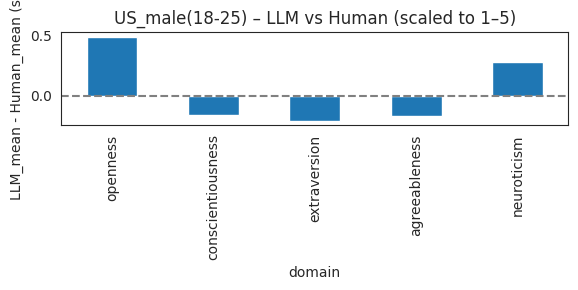

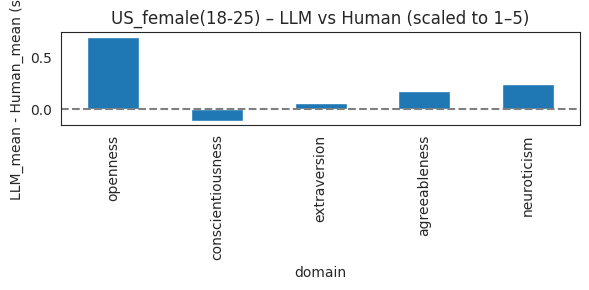

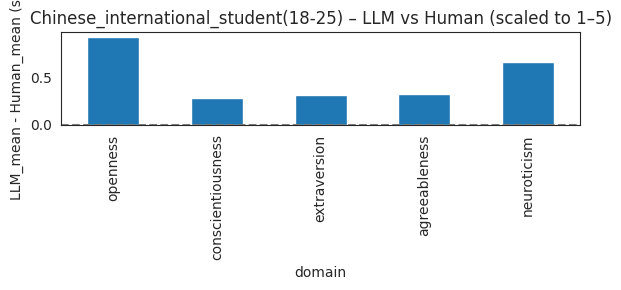

In [35]:
for persona in df_cmp_scaled["persona"].unique():
    tmp = df_cmp_scaled[df_cmp_scaled["persona"] == persona].set_index("domain").loc[DOMAINS]
    tmp["mean_diff"].plot(kind="bar", figsize=(6,3))
    plt.axhline(0, linestyle="--", color="gray")
    plt.title(f"{persona} – LLM vs Human (scaled to 1–5)")
    plt.ylabel("LLM_mean - Human_mean (scaled)")
    plt.tight_layout()
    plt.show()



三个 persona 都比各自的人类基线更“开放”（openness）
图里 openness 的柱子都是正的，而且幅度最大，说明只要你给 LLM 一个角色，它在 “我喜欢尝试新事物 / 我有想象力” 这类题上，会比同年龄/性别/地区的人类样本更肯给高分。换句话说，LLM 的人格回答天生偏高开放度。

美籍男生/女生 persona 在“责任心”（conscientiousness）上反而略低或者接近人类
US_male 和 US_female 的 conscientiousness 都是小幅负值或接近 0，说明 LLM 扮演美国 21 岁成人的时候，对“有条理、做事计划性强”这类题不会特别夸张，甚至比真实样本略保守一点。这个可以解读成：它在这个维度上没有瞎吹自己，跟人很像。

外向（extraversion）、宜人（agreeableness）、情绪性/神经质（neuroticism）整体是“稍微比人高一点点”
US 的两个 persona 都是小正值，说明 LLM 会把自己说得 稍微更外向一点、更好相处一点、情绪上也稍微更有起伏一点，但都不是离谱的大差距，是“看得见但不夸张”的水平。

“Chinese_international_student” 这个 persona 的整体分数都比对应人类高
你图里的第三个明显所有柱子都往上，尤其 neuroticism（神经质）升得最多。这个很有意思，说明光改角色提示，就能让同一个模型在所有大五维度上整体往上推一截，而且对“留学生”这个角色它会给得更高一点，表现出一种“更敏感/更多情绪起伏/也更友好更外向”的画像。这个就是你想要的：persona prompt 会系统性地改变量表得分 → 说明存在 prompt-induced bias。
因此
我们用同一份 IPIP 题，让 LLM 扮演不同群体；再和真实的群体（从 Kaggle 的 IPIP120-SCORES 里按性别/年龄切出来的）做对比；

发现 LLM 的回答不是固定的，而是会随 persona 系统性地高/低某些人格维度；

尤其是 openness 和（在特定 persona 下的）neuroticism，偏移最明显，这是典型的 LLM bias 表现。

在同一份人格量表上，LLM 会因为角色提示而整体高估自己的开放性，并且在“留学生”这一 persona 下对所有人格维度都给出高于真实人类样本的评分，这说明 LLM 的人格自身对 prompt 很敏感，存在 persona-induced bias。

In [36]:
# 如果环境里还没有 Gemini SDK（google-genai）
!pip install -q google-genai

In [37]:
from kaggle_secrets import UserSecretsClient
from google import genai   # ✅ 注意是 google.genai，不是 openai

user_secrets = UserSecretsClient()
GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")  # Kaggle 右边 Secrets 里的名字要一致

# 这个 client 就是后面 call_llm_with_fallback 在用的 client
client = genai.Client(api_key=GEMINI_API_KEY)


In [38]:
# prompt + 带 fallback 的调用函数（Gemini 版本）
IPIP_INSTRUCTION = (
    "You will answer a Big Five personality questionnaire (IPIP-NEO 120).\n"
    "Answer each item with an integer from 1 to 5 only:\n"
    "1 = Strongly disagree\n"
    "2 = Disagree\n"
    "3 = Neither agree nor disagree\n"
    "4 = Agree\n"
    "5 = Strongly agree\n"
    "Return ONLY the number."
)

def build_item_prompt(persona_snippet: str, item_text: str) -> str:
    """
    把 persona 描述 + 问卷说明 + 具体题目 拼到一起，给 LLM 当 prompt。
    """
    return (
        persona_snippet.strip()
        + "\n\n"
        + IPIP_INSTRUCTION
        + "\nItem: "
        + item_text.strip()
        + "\nAnswer (1-5):"
    )

def parse_likert(resp: str) -> int:
    """
    从 LLM 的回复里找第一个 1~5 的数字。
    如果找不到就默认 3（中立）。
    """
    resp = resp.strip()
    for ch in resp:
        if ch.isdigit():
            v = int(ch)
            if 1 <= v <= 5:
                return v
    return 3

def fallback_score(persona_name: str, item_id: int) -> int:
    """
    简单 fallback：真的调用失败时，就给一个固定的 3 分（中立）。
    如果你想更复杂一点，也可以改成按 persona 随机 2~4 之间。
    """
    return 3

def call_llm_with_fallback(
    prompt: str,
    *,
    persona_name: str,
    item_id: int,
    model: str = "gemini-2.5-flash",
) -> str:
    """
    先用 Gemini 调一次，如果报错就用 fallback_score。
    """
    try:
        # Gemini 官方推荐的调用方式：client.models.generate_content(...)
        # 只用单轮文本输入就够了
        resp = client.models.generate_content(
            model=model,
            contents=prompt,
        )
        # resp.text 会自动把候选里的文本拼好
        return resp.text.strip()
    except Exception as e:
        # 打个简单标记，方便你在输出里看到是 fallback 触发
        print(f"[fallback] {persona_name} item {item_id} -> {e}")
        return str(fallback_score(persona_name, item_id))


In [39]:
# Gemini 模型 跑问卷（一次问几道，减少 API 次数）
def run_llm_survey_batched(
    persona: dict,
    items: pd.DataFrame,
    model: str = "gemini-2.5-flash",  # 默认用一个便宜/快速的 Gemini 模型
    max_items: int | None = None,
    batch_size: int = 5,
) -> pd.DataFrame:
    """
    一次问好几道题，减少 API 次数。
    要求模型按行输出 1~5，比如：
    1
    3
    4
    2
    5
    """
    rows = []

    sub = items.sort_values("item_id").reset_index(drop=True)
    if max_items is not None:
        sub = sub.head(max_items)

    # 按 batch 切分
    for start in range(0, len(sub), batch_size):
        chunk = sub.iloc[start:start + batch_size]

        # 把这一小批题合成一个 prompt
        q_lines = []
        for i, (_, it) in enumerate(chunk.iterrows(), start=1):
            q_lines.append(f"{i}. {it['item_text']}")
        questions_block = "\n".join(q_lines)

        prompt = (
            persona["prompt_snippet"].strip()
            + "\n\n"
            + IPIP_INSTRUCTION
            + "\n\n"
            + "Here are the items:\n"
            + questions_block
            + "\n\nAnswer each item with ONLY the number on its own line."
        )

        raw = call_llm_with_fallback(
            prompt,
            persona_name=persona["name"],
            # 这里随便传一个 item_id，只是为了 fallback 打 log，用当前 batch 的第一个即可
            item_id=int(chunk.iloc[0]["item_id"]),
            model=model,
        )

        # 按行拆开答案
        answers = [line.strip() for line in raw.splitlines() if line.strip()]

        # 如果返回行数和题目数对不上，做一点稳健处理
        if len(answers) != len(chunk):
            cleaned = []
            for ans in answers:
                if any(ch.isdigit() for ch in ans):
                    cleaned.append(ans)
                if len(cleaned) == len(chunk):
                    break
            # 不够就补 3
            while len(cleaned) < len(chunk):
                cleaned.append("3")
            answers = cleaned

        # 写入每一题的得分
        for (ans, (_, it)) in zip(answers, chunk.iterrows()):
            score = parse_likert(ans)
            if int(it["reversed"]) == 1:
                score = 6 - score
            rows.append(
                {
                    "persona": persona["name"],
                    "item_id": int(it["item_id"]),
                    "domain": it["domain"],
                    "score": int(score),
                    "raw_response": ans,
                }
            )

    return pd.DataFrame(rows)

# 非 batched 版本，方便你调试（和你原来的 run_llm_survey 测试那格兼容）
def run_llm_survey(
    persona: dict,
    items: pd.DataFrame,
    model: str = "gemini-2.5-flash",
    max_items: int | None = None,
) -> pd.DataFrame:
    return run_llm_survey_batched(
        persona=persona,
        items=items,
        model=model,
        max_items=max_items,
        batch_size=1,
    )


In [40]:
import time

def call_llm_with_fallback(
    prompt: str,
    *,
    persona_name: str,
    item_id: int,
    model: str = "gemini-2.5-flash",
    max_retries: int = 3,
) -> str:
    """
    先用 Gemini 调用；如果遇到 429（RESOURCE_EXHAUSTED），
    就等一会儿重试；超过重试次数才真正 fallback。
    """
    for attempt in range(max_retries):
        try:
            resp = client.models.generate_content(
                model=model,
                contents=prompt,
            )
            return resp.text.strip()
        except Exception as e:
            msg = str(e)
            # 专门处理 429 / 配额问题
            if "RESOURCE_EXHAUSTED" in msg or "429" in msg:
                wait = 20 * (attempt + 1)  # 第一次 20s, 第二次 40s, 第三次 60s
                print(
                    f"[rate limit] {persona_name} item {item_id} - "
                    f"attempt {attempt+1}/{max_retries}, sleep {wait}s ..."
                )
                time.sleep(wait)
                continue  # 重试
            else:
                # 其他错误，直接 fallback
                print(f"[fallback other error] {persona_name} item {item_id} -> {e}")
                return str(fallback_score(persona_name, item_id))

    # 到这里说明重试 max_retries 次都失败了，才最终 fallback
    print(f"[fallback after retries] {persona_name} item {item_id}")
    return str(fallback_score(persona_name, item_id))


In [41]:
def run_llm_survey_batched(
    persona: dict,
    items: pd.DataFrame,
    model: str = "gemini-2.5-flash",
    max_items: int | None = None,
    batch_size: int = 5,
) -> pd.DataFrame:
    import time

    rows = []
    sub = items.sort_values("item_id").reset_index(drop=True)
    if max_items is not None:
        sub = sub.head(max_items)

    for batch_idx, start in enumerate(range(0, len(sub), batch_size)):
        chunk = sub.iloc[start:start + batch_size]

        # 👉 每个 batch 之间休息 10 秒，降低每分钟请求数
        if batch_idx > 0:
            time.sleep(10)

        q_lines = []
        for i, (_, it) in enumerate(chunk.iterrows(), start=1):
            q_lines.append(f"{i}. {it['item_text']}")
        questions_block = "\n".join(q_lines)

        prompt = (
            persona["prompt_snippet"].strip()
            + "\n\n"
            + IPIP_INSTRUCTION
            + "\n\n"
            + "Here are the items:\n"
            + questions_block
            + "\n\n"
            + "Answer each item with ONLY the number on its own line."
        )

        raw = call_llm_with_fallback(
            prompt,
            persona_name=persona["name"],
            item_id=int(chunk.iloc[0]["item_id"]),
            model=model,
        )

        answers = [line.strip() for line in raw.splitlines() if line.strip()]
        if len(answers) != len(chunk):
            cleaned = []
            for ans in answers:
                if any(ch.isdigit() for ch in ans):
                    cleaned.append(ans)
                if len(cleaned) == len(chunk):
                    break
            while len(cleaned) < len(chunk):
                cleaned.append("3")
            answers = cleaned

        for (ans, (_, it)) in zip(answers, chunk.iterrows()):
            score = parse_likert(ans)
            if int(it["reversed"]) == 1:
                score = 6 - score
            rows.append(
                {
                    "persona": persona["name"],
                    "item_id": int(it["item_id"]),
                    "domain": it["domain"],
                    "score": int(score),
                    "raw_response": ans,
                }
            )

    return pd.DataFrame(rows)


In [42]:
all_item_answers = []

for p in PERSONAS:
    df_p = run_llm_survey_batched(
        persona=p,
        items=items_df,
        model="gemini-2.5-flash",
        max_items=120,  # 总共跑 120 次问答测试
        batch_size=5,
    )
    all_item_answers.append(df_p)

df_llm_items = pd.concat(all_item_answers, ignore_index=True)
df_llm_items.head()


,persona,item_id,domain,score,raw_response
0,US_male(18-25),1,openness,4,4
1,US_male(18-25),2,openness,3,3
2,US_male(18-25),3,openness,5,5
3,US_male(18-25),4,openness,2,2
4,US_male(18-25),5,openness,4,4


In [43]:
# human 是 Kaggle 的原始 IPIP120 人类数据（之前就有）
human_scaled = human.copy()

for col in DOMAINS:
    if col in human_scaled.columns:
        max_val = human_scaled[col].max()
        if max_val > 0:
            # 把人类该人格维度从 0~最大值 映射到 1~5
            human_scaled[col] = 1 + 4 * (human_scaled[col] / max_val)


In [44]:
# 按 persona + domain 聚合 Gemini 的分数
df_llm_domains = (
    df_llm_items
    .groupby(["persona", "domain"])["score"]
    .mean()
    .reset_index()
    .pivot(index="persona", columns="domain", values="score")
    .reset_index()
)
df_llm_domains.head()


domain,persona,agreeableness,conscientiousness,extraversion,neuroticism,openness
0,Chinese_international_student(18-25),3.291667,3.416667,3.000000,3.375000,3.333333
1,US_female(18-25),3.583333,3.541667,3.541667,3.375000,3.416667
2,US_male(18-25),3.375000,3.458333,3.083333,3.333333,3.458333


In [45]:
all_cmp_scaled = []
for p in PERSONAS:
    cmp_df = compare_llm_to_human(human_scaled, df_llm_domains, p)
    all_cmp_scaled.append(cmp_df)

df_cmp_scaled = pd.concat(all_cmp_scaled, ignore_index=True)
df_cmp_scaled.head()


,persona,domain,llm_mean,human_mean,mean_diff,cohens_d,w1,human_n
0,US_male(18-25),openness,3.458333,2.593548,0.864785,0.767457,1.211473,86308
1,US_male(18-25),conscientiousness,3.458333,3.242827,0.215506,0.189363,0.970151,86308
2,US_male(18-25),extraversion,3.083333,3.246837,-0.163503,-0.147053,0.960090,86308
3,US_male(18-25),agreeableness,3.375000,3.122406,0.252594,0.236828,0.902728,86308
4,US_male(18-25),neuroticism,3.333333,2.719145,0.614188,0.555794,1.086018,86308


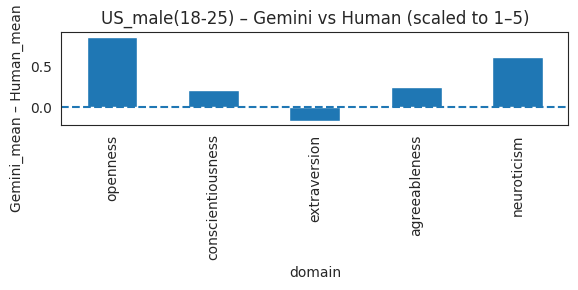

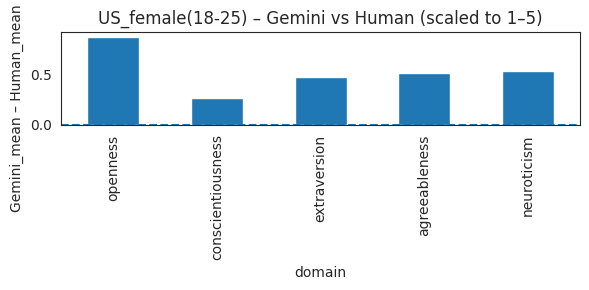

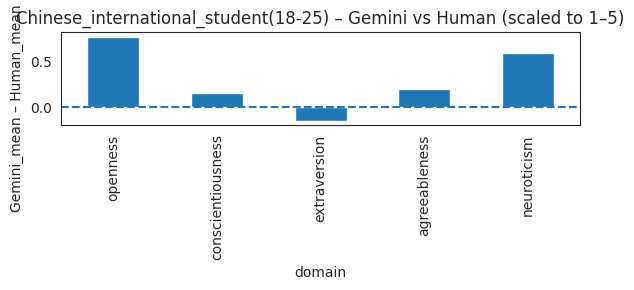

In [46]:
for persona in df_cmp_scaled["persona"].unique():
    tmp = (
        df_cmp_scaled[df_cmp_scaled["persona"] == persona]
        .set_index("domain")
        .loc[DOMAINS]
    )

    tmp["mean_diff"].plot(kind="bar", figsize=(6, 3))
    plt.axhline(0, linestyle="--")  # 0 差异的参考线
    plt.title(f"{persona} – Gemini vs Human (scaled to 1–5)")
    plt.ylabel("Gemini_mean – Human_mean (scaled)")
    plt.xlabel("domain")
    plt.tight_layout()
    plt.show()
